In [ ]:
!pip install transformers datasets scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import json
import pandas as pd

# Load your dataset from JSON file
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()


,text,Sentiment,Intent,sentiment,intent
0,"I'm a bit worried about my back pain, but I ho...",Anxious,Seeking reassurance,NaN,NaN
1,The medication you prescribed last week has be...,Reassured,Providing positive feedback,NaN,NaN
2,I need to schedule my follow-up appointment fo...,Neutral,Scheduling appointment,NaN,NaN
3,I've been having these chest pains for three d...,Anxious,Reporting symptoms,NaN,NaN
4,Thank you for explaining the procedure. I feel...,Reassured,Expressing gratitude,NaN,NaN


In [ ]:
# Remove unnamed or NaN columns
df = df[['text', 'Sentiment', 'Intent']]

# Rename columns to lowercase for consistency
df.columns = ['text', 'sentiment', 'intent']

# Confirm cleanup
df.head()


,text,sentiment,intent
0,"I'm a bit worried about my back pain, but I ho...",Anxious,Seeking reassurance
1,The medication you prescribed last week has be...,Reassured,Providing positive feedback
2,I need to schedule my follow-up appointment fo...,Neutral,Scheduling appointment
3,I've been having these chest pains for three d...,Anxious,Reporting symptoms
4,Thank you for explaining the procedure. I feel...,Reassured,Expressing gratitude


In [ ]:
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

# Encode the labels
sentiment_encoder = LabelEncoder()
intent_encoder = LabelEncoder()

df['sentiment_label'] = sentiment_encoder.fit_transform(df['sentiment'])
df['intent_label'] = intent_encoder.fit_transform(df['intent'])

# Save class names (optional)
sentiment_classes = sentiment_encoder.classes_
intent_classes = intent_encoder.classes_

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Check
df.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,text,sentiment,intent,sentiment_label,intent_label
0,"I'm a bit worried about my back pain, but I ho...",Anxious,Seeking reassurance,0,36
1,The medication you prescribed last week has be...,Reassured,Providing positive feedback,2,21
2,I need to schedule my follow-up appointment fo...,Neutral,Scheduling appointment,1,33
3,I've been having these chest pains for three d...,Anxious,Reporting symptoms,0,28
4,Thank you for explaining the procedure. I feel...,Reassured,Expressing gratitude,2,8


In [ ]:
import torch
from torch.utils.data import Dataset

# Tokenize all the text
encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)

# Custom Dataset class
class MedicalSentimentDataset(Dataset):
    def __init__(self, encodings, sentiment_labels, intent_labels):
        self.encodings = encodings
        self.sentiment_labels = sentiment_labels
        self.intent_labels = intent_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['sentiment_labels'] = torch.tensor(self.sentiment_labels[idx])
        item['intent_labels'] = torch.tensor(self.intent_labels[idx])
        return item

    def __len__(self):
        return len(self.sentiment_labels)

# Create dataset
dataset = MedicalSentimentDataset(encodings, df['sentiment_label'].tolist(), df['intent_label'].tolist())


In [ ]:
import torch.nn as nn
from transformers import BertModel

class MultiTaskBERT(nn.Module):
    def __init__(self, model_name, num_sentiment_labels, num_intent_labels):
        super(MultiTaskBERT, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, num_intent_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)
        return sentiment_logits, intent_logits


In [ ]:
print(df.columns)


Index(['text', 'sentiment', 'intent', 'sentiment_label', 'intent_label'], dtype='object')


In [ ]:
# Remove rows with missing sentiment or intent
df = df.dropna(subset=['sentiment', 'intent'])


In [ ]:
df.shape

(210, 5)

In [ ]:
unique_sentiments = df['sentiment'].unique()
unique_intents = df['intent'].unique()

sentiment2id = {label: idx for idx, label in enumerate(unique_sentiments)}
intent2id = {label: idx for idx, label in enumerate(unique_intents)}

id2sentiment = {v: k for k, v in sentiment2id.items()}
id2intent = {v: k for k, v in intent2id.items()}


In [ ]:
num_sentiment_labels = len(sentiment2id)
num_intent_labels = len(intent2id)


In [ ]:
num_sentiment_labels
num_intent_labels

37

In [ ]:


# Print to verify
print("Sentiment2ID:", sentiment2id)
print("Intent2ID:", intent2id)


Sentiment2ID: {'Anxious': 0, 'Reassured': 1, 'Neutral': 2}
Intent2ID: {'Seeking reassurance': 0, 'Providing positive feedback': 1, 'Scheduling appointment': 2, 'Reporting symptoms': 3, 'Expressing gratitude': 4, 'Seeking guidance': 5, 'Expressing frustration': 6, 'Providing positive update': 7, 'Administrative request': 8, 'Reporting side effects': 9, 'Seeking confirmation': 10, 'Expressing concern': 11, 'Requesting timeline': 12, 'Expressing confidence': 13, 'Reporting measurements': 14, 'Expressing fear': 15, 'Confirming compliance': 16, 'Financial concern': 17, 'Expressing relief': 18, 'Expressing comfort': 19, 'Confirming appointment': 20, 'Requesting information': 21, 'Providing lifestyle information': 22, 'Providing background information': 23, 'Providing medical history': 24, 'Expressing regret': 25, 'Providing physical information': 26, 'Requesting alternatives': 27, 'Requesting clarification': 28, 'Expressing readiness': 29, 'Expressing hope': 30, 'Providing social information

In [ ]:
# Filter out any nulls before creating label encodings
unique_sentiments = df['sentiment'].dropna().unique()
unique_intents = df['intent'].dropna().unique()

# Create mapping dictionaries
sentiment2id = {label: idx for idx, label in enumerate(unique_sentiments)}
intent2id = {label: idx for idx, label in enumerate(unique_intents)}

id2sentiment = {v: k for k, v in sentiment2id.items()}
id2intent = {v: k for k, v in intent2id.items()}

# Count labels
num_sentiment_labels = len(sentiment2id)
num_intent_labels = len(intent2id)

print("Sentiment2ID:", sentiment2id)
print("Intent2ID:", intent2id)
print("Sentiment Labels:", num_sentiment_labels)
print("Intent Labels:", num_intent_labels)


Sentiment2ID: {'Anxious': 0, 'Reassured': 1, 'Neutral': 2}
Intent2ID: {'Seeking reassurance': 0, 'Providing positive feedback': 1, 'Scheduling appointment': 2, 'Reporting symptoms': 3, 'Expressing gratitude': 4, 'Seeking guidance': 5, 'Expressing frustration': 6, 'Providing positive update': 7, 'Administrative request': 8, 'Reporting side effects': 9, 'Seeking confirmation': 10, 'Expressing concern': 11, 'Requesting timeline': 12, 'Expressing confidence': 13, 'Reporting measurements': 14, 'Expressing fear': 15, 'Confirming compliance': 16, 'Financial concern': 17, 'Expressing relief': 18, 'Expressing comfort': 19, 'Confirming appointment': 20, 'Requesting information': 21, 'Providing lifestyle information': 22, 'Providing background information': 23, 'Providing medical history': 24, 'Expressing regret': 25, 'Providing physical information': 26, 'Requesting alternatives': 27, 'Requesting clarification': 28, 'Expressing readiness': 29, 'Expressing hope': 30, 'Providing social information

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class MultiTaskBERT(nn.Module):
    def __init__(self, model_name, num_sentiment_labels, num_intent_labels):
        super(MultiTaskBERT, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        hidden_size = self.bert.config.hidden_size

        # Classification heads
        self.sentiment_classifier = nn.Linear(hidden_size, num_sentiment_labels)
        self.intent_classifier = nn.Linear(hidden_size, num_intent_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token representation

        sentiment_logits = self.sentiment_classifier(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)

        return sentiment_logits, intent_logits


In [ ]:
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, encodings, sentiment_labels, intent_labels):
        self.encodings = encodings
        self.sentiment_labels = sentiment_labels
        self.intent_labels = intent_labels

    def __len__(self):
        return len(self.sentiment_labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'sentiment_label': torch.tensor(self.sentiment_labels[idx], dtype=torch.long),
            'intent_label': torch.tensor(self.intent_labels[idx], dtype=torch.long),
        }
        return item


In [ ]:
from torch.utils.data import DataLoader

dataset = MultiTaskDataset(encodings, df["sentiment_label"].tolist(), df["intent_label"].tolist())
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
model_name = "bert-base-uncased"


In [ ]:
model = MultiTaskBERT(model_name, num_sentiment_labels, num_intent_labels)
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    sentiment_correct = 0
    intent_correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiment_labels = batch['sentiment_label'].to(device)
        intent_labels = batch['intent_label'].to(device)

        optimizer.zero_grad()

        sentiment_logits, intent_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )


        loss_sentiment = criterion(sentiment_logits, sentiment_labels)
        loss_intent = criterion(intent_logits, intent_labels)
        loss = loss_sentiment + loss_intent

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy tracking
        sentiment_preds = torch.argmax(sentiment_logits, dim=1)
        intent_preds = torch.argmax(intent_logits, dim=1)
        sentiment_correct += (sentiment_preds == sentiment_labels).sum().item()
        intent_correct += (intent_preds == intent_labels).sum().item()
        total += sentiment_labels.size(0)

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item(),
                         sentiment_acc=sentiment_correct / total,
                         intent_acc=intent_correct / total)


Epoch 3: 100%|██████████| 27/27 [00:01<00:00, 13.65it/s, intent_acc=0.224, loss=4.49, sentiment_acc=0.757]


In [ ]:
model_save_path = "multitask_bert_model.pt"  # Use .pt extension for PyTorch state dict
tokenizer_save_path = "multitask_bert_tokenizer"

# Save model state dictionary
torch.save(model.state_dict(), model_save_path)

# Save tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model state dictionary saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Model state dictionary saved to multitask_bert_model.pt
Tokenizer saved to multitask_bert_tokenizer


In [ ]:
model.eval()
sample_batch = next(iter(dataloader))
input_ids = sample_batch['input_ids'].to(device)
attention_mask = sample_batch['attention_mask'].to(device)

with torch.no_grad():
    sentiment_logits, intent_logits = model(input_ids=input_ids, attention_mask=attention_mask)

sentiment_preds = torch.argmax(sentiment_logits, dim=1)
intent_preds = torch.argmax(intent_logits, dim=1)

print("Predicted Sentiments:", sentiment_preds)
print("Predicted Intents:", intent_preds)


Predicted Sentiments: tensor([1, 0, 1, 1, 1, 2, 0, 1], device='cuda:0')
Predicted Intents: tensor([28,  4, 28, 28, 28,  4, 31, 28], device='cuda:0')


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn

class MultiTaskBERT(nn.Module):
    def __init__(self, model_name, num_sentiment_labels, num_intent_labels):
        super(MultiTaskBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.sentiment_classifier = nn.Linear(self.bert.config.hidden_size, num_sentiment_labels)
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, num_intent_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        intent_logits = self.intent_classifier(pooled_output)
        return sentiment_logits, intent_logits


In [ ]:
from transformers import AutoTokenizer

# Paths
model_path = "multitask_bert_model.pt"
tokenizer_path = "multitask_bert_tokenizer"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Reload model
model = MultiTaskBERT("bert-base-uncased", num_sentiment_labels=3, num_intent_labels=37)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
model.eval()


MultiTaskBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
text = "I'm a bit worried about my back pain, but I hope it gets better soon."

# Encode
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Predict
with torch.no_grad():
    sentiment_logits, intent_logits = model(input_ids=inputs["input_ids"],
                                            attention_mask=inputs["attention_mask"])

# Decode
predicted_sentiment = torch.argmax(sentiment_logits, dim=1).item()
predicted_intent = torch.argmax(intent_logits, dim=1).item()

# Map back to labels
print("Predicted Sentiment:", id2sentiment[predicted_sentiment])
print("Predicted Intent:", id2intent[predicted_intent])


Predicted Sentiment: Anxious
Predicted Intent: Expressing gratitude


In [ ]:
test_texts = [
    "I'm a bit worried about my back pain, but I hope it gets better soon.",
    "Thank you for your help, doctor. I really appreciate it.",
    "I need to schedule my next check-up appointment.",
    "These side effects are making me feel worse than before.",
    "The medication is working great! I feel so much better.",
]


In [ ]:
model.eval()  # Set model to evaluation mode
model.to("cuda")  # Move model to GPU

test_texts = [
    "I'm feeling a bit anxious about my recovery.",
    "Thanks for your help, I feel much better now.",
    "I need to book a follow-up appointment soon.",
    "I've been having chest pains for three days."
]

for text in test_texts:
    # Tokenize and send tensors to GPU
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to("cuda")
    attention_mask = inputs['attention_mask'].to("cuda")

    # Forward pass
    with torch.no_grad():
        sentiment_logits, intent_logits = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get predictions
    sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()
    intent_pred = torch.argmax(intent_logits, dim=1).item()

    # Convert ID to label
    sentiment_label = id2sentiment[sentiment_pred]
    intent_label = id2intent[intent_pred]

    # Print results
    print(f"🗣️ Input: {text}")
    print(f"🧠 Predicted Sentiment: {sentiment_label}")
    print(f"🎯 Predicted Intent: {intent_label}")
    print("-" * 50)


🗣️ Input: I'm feeling a bit anxious about my recovery.
🧠 Predicted Sentiment: Anxious
🎯 Predicted Intent: Expressing gratitude
--------------------------------------------------
🗣️ Input: Thanks for your help, I feel much better now.
🧠 Predicted Sentiment: Neutral
🎯 Predicted Intent: Expressing gratitude
--------------------------------------------------
🗣️ Input: I need to book a follow-up appointment soon.
🧠 Predicted Sentiment: Reassured
🎯 Predicted Intent: Requesting clarification
--------------------------------------------------
🗣️ Input: I've been having chest pains for three days.
🧠 Predicted Sentiment: Anxious
🎯 Predicted Intent: Requesting clarification
--------------------------------------------------


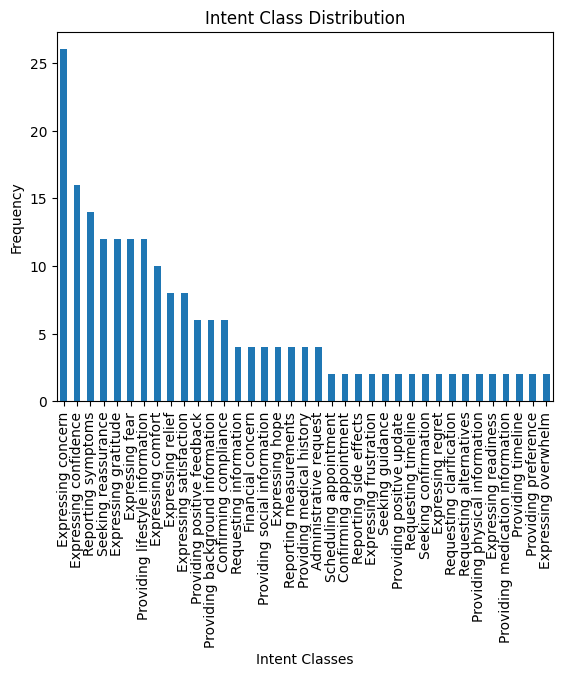

In [ ]:
import matplotlib.pyplot as plt

# Intent label distribution
df['intent'].value_counts().plot(kind='bar', title='Intent Class Distribution')
plt.xlabel("Intent Classes")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import torch

# Count and normalize class weights
intent_counts = df['intent_label'].value_counts().sort_index()
intent_weights = 1.0 / intent_counts
intent_weights = intent_weights / intent_weights.sum()
intent_class_weights = torch.tensor(intent_weights.values, dtype=torch.float).to(device)

# Replace intent loss with weighted version
intent_criterion = torch.nn.CrossEntropyLoss(weight=intent_class_weights)


In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 1: Compute class weights for intent (to handle class imbalance)
intent_counts = np.zeros(len(intent2id))
for label in df['intent_label']:
    intent_counts[label] += 1

intent_weights = 1.0 / (intent_counts + 1e-5)  # to avoid division by zero
intent_weights = intent_weights / intent_weights.sum()  # normalize

intent_class_weights = torch.tensor(intent_weights, dtype=torch.float).to(device)

# Step 2: Define loss functions
criterion_sentiment = nn.CrossEntropyLoss()
criterion_intent = nn.CrossEntropyLoss(weight=intent_class_weights)  # weighted loss

# Step 3: Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Step 4: Training loop
epochs = 5  # Increase if needed

for epoch in range(epochs):
    model.train()
    total_loss = 0
    sentiment_correct = 0
    intent_correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiment_labels = batch['sentiment_label'].to(device)
        intent_labels = batch['intent_label'].to(device)

        optimizer.zero_grad()

        sentiment_logits, intent_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Compute losses
        loss_sentiment = criterion_sentiment(sentiment_logits, sentiment_labels)
        loss_intent = criterion_intent(intent_logits, intent_labels)
        loss = loss_sentiment + loss_intent

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy tracking
        sentiment_preds = torch.argmax(sentiment_logits, dim=1)
        intent_preds = torch.argmax(intent_logits, dim=1)
        sentiment_correct += (sentiment_preds == sentiment_labels).sum().item()
        intent_correct += (intent_preds == intent_labels).sum().item()
        total += sentiment_labels.size(0)

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item(),
                         sentiment_acc=sentiment_correct / total,
                         intent_acc=intent_correct / total)

# Optional: Save the model
torch.save(model.state_dict(), "balanced_multitask_bert.pt")


Epoch 5: 100%|██████████| 27/27 [00:03<00:00,  8.44it/s, intent_acc=0.652, loss=2.4, sentiment_acc=0.967]


In [ ]:
# Example sentences to test
test_sentences = [
    "I'm feeling a bit anxious about my recovery.",
    "Thanks for your help, I feel much better now.",
    "I need to book a follow-up appointment soon.",
    "I've been having chest pains for three days.",
    "Is it safe to continue my current medication?",
    "Can I get a timeline for when I’ll be fully recovered?",
    "I’m confident in the treatment plan you gave me."
]

# Move model to evaluation mode
model.eval()

# Loop through test inputs
for text in test_sentences:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        sentiment_logits, intent_logits = model(input_ids=input_ids, attention_mask=attention_mask)

    sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()
    intent_pred = torch.argmax(intent_logits, dim=1).item()

    sentiment_label = id2sentiment[sentiment_pred]
    intent_label = id2intent[intent_pred]

    print("🗣️ Input:", text)
    print("🧠 Predicted Sentiment:", sentiment_label)
    print("🎯 Predicted Intent:", intent_label)
    print("-" * 50)


🗣️ Input: I'm feeling a bit anxious about my recovery.
🧠 Predicted Sentiment: Anxious
🎯 Predicted Intent: Expressing gratitude
--------------------------------------------------
🗣️ Input: Thanks for your help, I feel much better now.
🧠 Predicted Sentiment: Neutral
🎯 Predicted Intent: Requesting information
--------------------------------------------------
🗣️ Input: I need to book a follow-up appointment soon.
🧠 Predicted Sentiment: Reassured
🎯 Predicted Intent: Providing medication information
--------------------------------------------------
🗣️ Input: I've been having chest pains for three days.
🧠 Predicted Sentiment: Anxious
🎯 Predicted Intent: Expressing gratitude
--------------------------------------------------
🗣️ Input: Is it safe to continue my current medication?
🧠 Predicted Sentiment: Reassured
🎯 Predicted Intent: Requesting clarification
--------------------------------------------------
🗣️ Input: Can I get a timeline for when I’ll be fully recovered?
🧠 Predicted Sentiment

In [ ]:
torch.save(model.state_dict(), "multitask_model.pth")


In [ ]:
import torch

# Save model weights
torch.save(model.state_dict(), "multitask_bert_baseline.pt")

# Save tokenizer
tokenizer.save_pretrained("tokenizer_baseline/")


('tokenizer_baseline/tokenizer_config.json',
 'tokenizer_baseline/special_tokens_map.json',
 'tokenizer_baseline/vocab.txt',
 'tokenizer_baseline/added_tokens.json',
 'tokenizer_baseline/tokenizer.json')

In [ ]:
intent_counts = df['intent'].value_counts()
print("📊 Intent Label Frequencies:\n")
print(intent_counts)


📊 Intent Label Frequencies:

intent
Expressing concern                  26
Expressing confidence               16
Reporting symptoms                  14
Seeking reassurance                 12
Expressing gratitude                12
Expressing fear                     12
Providing lifestyle information     12
Expressing comfort                  10
Expressing relief                    8
Expressing satisfaction              8
Providing positive feedback          6
Providing background information     6
Confirming compliance                6
Requesting information               4
Financial concern                    4
Providing social information         4
Expressing hope                      4
Reporting measurements               4
Providing medical history            4
Administrative request               4
Scheduling appointment               2
Confirming appointment               2
Reporting side effects               2
Expressing frustration               2
Seeking guidance            

In [ ]:
!pip install sentencepiece


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load T5 base model for paraphrasing
paraphrase_model = AutoModelForSeq2SeqLM.from_pretrained("ramsrigouthamg/t5_paraphraser")
paraphrase_tokenizer = AutoTokenizer.from_pretrained("ramsrigouthamg/t5_paraphraser")

def paraphrase_text(text, max_return_sequences=3):
    input_text = f"paraphrase: {text} </s>"
    encoding = paraphrase_tokenizer.encode_plus(input_text, padding='max_length', return_tensors="pt", max_length=128, truncation=True)
    input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]

    outputs = paraphrase_model.generate(
    input_ids=input_ids,
    attention_mask=attention_masks,
    max_length=128,
    num_return_sequences=max_return_sequences,
    num_beams=5,
    early_stopping=True
)


    return [paraphrase_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]


In [ ]:
import pandas as pd
from collections import Counter

# Example: assuming df contains 'text' and 'intent'
intent_counts = df['intent'].value_counts()
rare_intents = intent_counts[intent_counts < 8].index.tolist()

augmented_data = []

for intent in rare_intents:
    intent_rows = df[df['intent'] == intent]
    for _, row in intent_rows.iterrows():
        try:
            new_texts = paraphrase_text(row['text'], max_return_sequences=3)
            for new_text in new_texts:
                augmented_data.append({
                    "text": new_text,
                    "intent": row['intent'],
                    "sentiment": row['sentiment']  # Keep original sentiment
                })
        except Exception as e:
            print(f"Skipping: {row['text']} due to error: {e}")


In [ ]:
import pandas as pd

# Convert to DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Optionally print a few rows
print("Sample of Augmented Data:\n", augmented_df.head())

# Combine with original data
final_df = pd.concat([df, augmented_df], ignore_index=True)

# Shuffle the combined dataset (important!)
final_df = final_df.sample(frac=1).reset_index(drop=True)

# Optional: Save to CSV or JSON
final_df.to_csv("augmented_dataset.csv", index=False)
print("✅ Final dataset saved as 'augmented_dataset.csv'")


Sample of Augmented Data:
                                                 text  \
0  What medication did you prescribe to me last w...   
1    What medication did you prescribe me last week?   
2  What is the medication you prescribed to me la...   
3  What are the benefits of physical therapy for me?   
4  What are the benefits of physical therapy for ...   

                        intent  sentiment  
0  Providing positive feedback  Reassured  
1  Providing positive feedback  Reassured  
2  Providing positive feedback  Reassured  
3  Providing positive feedback  Reassured  
4  Providing positive feedback  Reassured  
✅ Final dataset saved as 'augmented_dataset.csv'


In [ ]:
# Load your augmented dataset
import pandas as pd

df = pd.read_csv("augmented_dataset.csv")

# Encode labels again
intent2id = {label: idx for idx, label in enumerate(df["intent"].unique())}
sentiment2id = {label: idx for idx, label in enumerate(df["sentiment"].unique())}

df["intent_label"] = df["intent"].map(intent2id)
df["sentiment_label"] = df["sentiment"].map(sentiment2id)


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

inputs = tokenizer(
    list(df["text"]),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Build PyTorch dataset
import torch
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(
    inputs["input_ids"],
    inputs["attention_mask"],
    torch.tensor(df["sentiment_label"].values),
    torch.tensor(df["intent_label"].values)
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

epochs = 2  # Optional: retrain for fewer epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0
    sentiment_correct = 0
    intent_correct = 0
    total = 0

    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        input_ids, attention_mask, sentiment_labels, intent_labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        sentiment_logits, intent_logits = model(input_ids=input_ids, attention_mask=attention_mask)

        loss_sentiment = criterion(sentiment_logits, sentiment_labels)
        loss_intent = criterion(intent_logits, intent_labels)
        loss = loss_sentiment + loss_intent

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        sentiment_correct += (torch.argmax(sentiment_logits, dim=1) == sentiment_labels).sum().item()
        intent_correct += (torch.argmax(intent_logits, dim=1) == intent_labels).sum().item()
        total += sentiment_labels.size(0)

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item(),
                         sentiment_acc=sentiment_correct / total,
                         intent_acc=intent_correct / total)


Epoch 2: 100%|██████████| 29/29 [00:03<00:00,  8.99it/s, intent_acc=0.564, loss=1.75, sentiment_acc=0.991]


In [ ]:
import os
output_dir = "./saved_multitask_model"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save model state
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

# Save tokenizer
tokenizer.save_pretrained(output_dir)

# Save label mappings
import json
with open(os.path.join(output_dir, "intent2id.json"), "w") as f:
    json.dump(intent2id, f)
with open(os.path.join(output_dir, "sentiment2id.json"), "w") as f:
    json.dump(sentiment2id, f)


In [ ]:
# Load tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("./saved_multitask_model")

# Re-initialize model
model = MultiTaskBERT("bert-base-uncased", num_sentiment_labels=len(sentiment2id), num_intent_labels=len(intent2id))
model.load_state_dict(torch.load("./saved_multitask_model/pytorch_model.bin"))
model.to(device)
model.eval()


MultiTaskBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise